In [1]:
import os
import gc
import re
import math
import string
import emoji
import numpy as np
import pandas as pd
import fasttext
import torch
import torch.nn as nn
from bs4 import BeautifulSoup
from torch import optim
from tqdm import tqdm
from sklearn.model_selection import train_test_split

from transformers import BertForSequenceClassification, DistilBertModel
from transformers import AutoTokenizer, TrainingArguments, Trainer
from transformers import DataCollatorWithPadding
from torch.utils.data import Dataset, DataLoader
import evaluate
import warnings  

warnings.filterwarnings('ignore')
os.environ["TOKENIZERS_PARALLELISM"] = "false"
torch.set_float32_matmul_precision('high')

/home/maxim/anaconda3/envs/bert_clasify/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
def set_random_seed(seed):
    """
    Set the random seed for NumPy and PyTorch.
    Parameters:
    seed (int): The seed value to set for random number generation.
    """
    np.random.seed(seed)  # Set seed for NumPy
    torch.manual_seed(seed)  # Set seed for CPU
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)  # Set seed for GPU
        torch.cuda.manual_seed_all(seed) #Set for all GPUs

set_random_seed(42)

In [4]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", 
                       "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", 
                       "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", 
                       "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am",
                       "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", 
                       "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have",
                       "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not",
                       "mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", 
                       "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
                       "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", 
                       "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have",
                       "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is",
                       "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would",
                       "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have",
                       "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have",
                       "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", 
                       "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did",
                       "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", 
                       "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", 
                       "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                       "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have",
                       "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have", 'u.s':'america', 'e.g':'for example'}

punct = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…', 
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', 
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

punct_mapping = {"‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", "×": "x", "²": "2", "—": "-", "–": "-", "’": "'", "_": "-",
                 "`": "'", '“': '"', '”': '"', '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 'à': 'a', '−': '-', 
                 'β': 'beta', '∅': '', '³': '3', 'π': 'pi', '!':' '}
#Самые распространенные ошибки
mispell_dict = {'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater',
                'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ',
                'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What', 'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can',
                'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does', 
                'mastrubation': 'masturbation', 'mastrubate': 'masturbate', "mastrubating": 'masturbating', 'pennis': 'penis', 'Etherium': 'Ethereum', 
                'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend', 
                'airhostess': 'air hostess', "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization',
                'demonetisation': 'demonetization'}



In [5]:
def clean_text(text):
    '''Clean emoji, Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = emoji.demojize(text)
    text = re.sub(r'\:(.*?)\:','',text)
    text = str(text).lower()    #Making Text Lowercase
    text = re.sub('\[.*?\]', '', text)
    #The next 2 lines remove html text
    text = BeautifulSoup(text, 'lxml').get_text()
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",", "'")
    text = re.sub(r"[^a-zA-Z?.!,¿']+", " ", text)
    return text

def clean_contractions(text, mapping):
    '''Clean contraction using contraction mapping'''    
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    for word in mapping.keys():
        if ""+word+"" in text:
            text = text.replace(""+word+"", ""+mapping[word]+"")
    #Remove Punctuations
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    text = re.sub(r"([?.!,¿])", r" \1 ", text)
    text = re.sub(r'[" "]+', " ", text)
    return text

def clean_special_chars(text, punct, mapping):
    '''Cleans special characters present(if any)'''   
    for p in mapping:
        text = text.replace(p, mapping[p])
    
    for p in punct:
        text = text.replace(p, f' {p} ')
    
    specials = {'\u200b': ' ', '…': ' ... ', '\ufeff': '', 'करना': '', 'है': ''}  
    for s in specials:
        text = text.replace(s, specials[s])
    
    return text

def correct_spelling(x, dic):
    '''Corrects common spelling errors'''   
    for word in dic.keys():
        x = x.replace(word, dic[word])
    return x

def remove_space(text):
    '''Removes awkward spaces'''   
    #Removes awkward spaces 
    text = text.strip()
    text = text.split()
    return " ".join(text)

def text_preprocessing_pipeline(text):
    '''Cleaning and parsing the text.'''
    text = clean_text(text)
    text = clean_contractions(text, contraction_mapping)
    text = clean_special_chars(text, punct, punct_mapping)
    text = correct_spelling(text, mispell_dict)
    text = remove_space(text)
    return text

In [6]:
df1 = pd.read_csv('data/goemotions_1.csv')
df2 = pd.read_csv('data/goemotions_2.csv')
df3 = pd.read_csv('data/goemotions_3.csv')
print(df1.shape, df2.shape, df3.shape)

df = pd.concat((df1, df2, df3))

(70000, 37) (70000, 37) (71225, 37)


In [7]:
df['text'] = df['text'].apply(text_preprocessing_pipeline)

In [8]:
filter = df['text'].apply(lambda x: len(x) in range(0, 3))
df = df[~filter]
filter = df['example_very_unclear'] != True
df = df[filter]

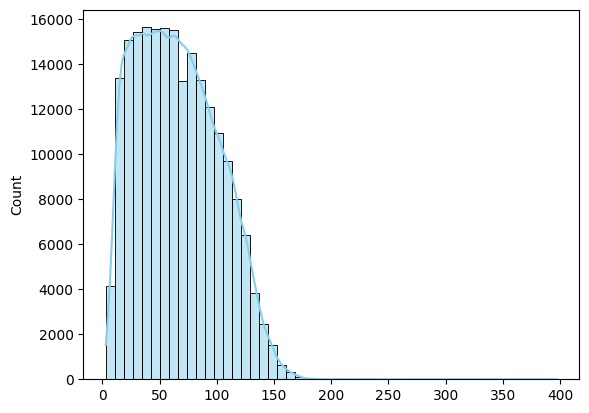

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns


hist = sns.histplot(df['text'].str.len().values, 
                    bins=50, 
                    color='skyblue', 
                    edgecolor='black', 
                    kde=True)
plt.show()

In [10]:
# df, waste_df = train_test_split(df, test_size=.96, shuffle=True)
train_df, test_df = train_test_split(df, test_size=.3, shuffle=True)

train_df = train_df.reset_index()
emotions = train_df.loc[:, 'admiration':'neutral'].columns
bin_idx = train_df.loc[:, 'admiration':'neutral'].values == 1
with open('train_data.txt', 'w') as f:
    for i in range(train_df.shape[0]):
        f.write(' '.join(['__label__' + i for i in emotions[bin_idx[i]]]) + ' ' + train_df.reset_index().loc[i, 'text']+'\n')
        

test_df = test_df.reset_index()
emotions = test_df.loc[:, 'admiration':'neutral'].columns
bin_idx = test_df.loc[:, 'admiration':'neutral'].values == 1
with open('test_data.txt', 'w') as f:
    for i in range(test_df.shape[0]):
        f.write(' '.join(['__label__' + i for i in emotions[bin_idx[i]]]) + ' ' + test_df.reset_index().loc[i, 'text'] + '\n')

In [ ]:
model = fasttext.train_supervised(
    input = 'train_data.train',
    autotuneValidationFile = 'test_data.txt',
    epoch = 50,
    loss = 'ova',
    autotuneMetric = 'f1'
)
model.save_model('fasttext.bin')

Progress: 100.0% Trials:   31 Best score:  0.536065 ETA:   0h 0m 0s
Training again with best arguments
Read 2M words
Number of words:  30151
Number of labels: 28
Progress: 100.0% words/sec/thread:  345854 lr:  0.000000 avg.loss:  2.660721 ETA:   0h 0m 0s% words/sec/thread:  349231 lr:  0.041191 avg.loss:  3.806973 ETA:   0h 0m17s 346987 lr:  0.024202 avg.loss:  3.156097 ETA:   0h 0m10s words/sec/thread:  346926 lr:  0.016868 avg.loss:  2.973224 ETA:   0h 0m 7sm 0s


In [3]:
model.test('test_data.txt', k = 28)

(62281, 0.042871364117008856, 1.0)

In [ ]:
# df.loc[:, 'admiration':].sum(axis=0)
# Для каждого класса: pos_weight = (количество негативных примеров) / (количество позитивных)
positive_counts = train_df.loc[:, 'admiration':'neutral'].sum(axis=0).values  # Число позитивных примеров по классам
negative_counts = len(train_df) - positive_counts                             # Число негативных примеров
pos_weights = (negative_counts / positive_counts).astype(np.float32)          # Соотношение негативных к позитивным

# Преобразуем в тензор и отправляем на устройство (GPU)
pos_weights_tensor = torch.tensor(pos_weights, device=device)
pos_weights_tensor

tensor([ 11.4166,  21.9413,  25.0541,  14.4889,  10.8827,  33.6513,  27.6823,
         20.6355,  54.5853,  23.8834,  17.6312,  39.0046,  84.5654,  36.6514,
         64.6559,  17.1175, 300.1344,  25.3701,  24.7009, 116.6269,  23.3546,
        163.2856,  22.8787, 162.9213,  82.2528,  29.8678,  36.8732,   2.8329],
       device='cuda:0')

In [ ]:
class TextDataset(Dataset):
    def __init__(self, df, tokenizer):
        self.tokenizer = tokenizer
        self.text = df.text.values
        emotions = df.loc[:, 'admiration':'neutral']
        self.emotion_names = emotions.columns
        self.emotions_values =emotions.values
    def __getitem__(self, idx):
        dict_idx = self.tokenizer(self.text[idx], truncation=True, padding='max_length', max_length=512, return_tensors="pt")
        dict_idx['labels'] = self.emotions_values[idx]
        return dict_idx
    def __len__(self):return self.text.shape[0]

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
train_dataset = TextDataset(train_df, tokenizer = tokenizer)
test_dataset = TextDataset(test_df,tokenizer = tokenizer)

In [ ]:
lr = 3e-4
batch_size = 32
num_epochs = 50

train_loader = DataLoader(train_dataset, batch_size, shuffle = True, num_workers=6)
test_loader = DataLoader(test_dataset, batch_size, shuffle = True, num_workers=6)

In [ ]:
accuracy = evaluate.load("accuracy")

In [ ]:
class CosineLearningRate():
    def __init__(self, max_lr, min_lr, warmupsteps, max_steps):
        self.max_lr = max_lr
        self.min_lr = min_lr
        self.warmupsteps = warmupsteps
        self.max_steps = max_steps
    
    def get_lr(self, it):
        if it < self.warmupsteps:
            return self.max_lr * (it + 1)
        if it > self.max_steps:
            return self.min_lr
        decay_ratio = (it - self.warmupsteps) / (self.max_steps - self.warmupsteps)
        assert 0 <= decay_ratio <= 1
        coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio))
        return self.min_lr + coeff * (self.max_lr - self.min_lr)

class DistillBertClass(torch.nn.Module):
    def __init__(self, d_model, nclasses, dropout = .2):
        super(DistillBertClass, self).__init__()
        self.bert = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.pre_classifier = torch.nn.Linear(768, d_model)
        self.dropout = torch.nn.Dropout(dropout)
        self.classifier = torch.nn.Linear(d_model, nclasses)

    def forward(self, input_ids, attention_mask = None):
        output_1 = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1['last_hidden_state']
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output


In [ ]:
len(train_dataset.emotion_names)

28

In [ ]:
model = DistillBertClass(d_model = 768, nclasses=len(train_dataset.emotion_names)).to(device)
model = torch.compile(model)

In [ ]:
from tqdm import tqdm
import time
cos_lr = CosineLearningRate(max_lr = 6e-4, 
                            min_lr = 6e-4 * 0.1,
                            warmupsteps=10,
                            max_steps = 50)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr = 6e-4, betas = (0.9, 0.95), eps = 1e-8, fused=True)
epochs = 50
train_loss_per_epoch = np.zeros(epochs)
val_loss_per_epoch = np.zeros(epochs)
for epoch in tqdm(range(epochs), bar_format='{l_bar}{bar:20}{r_bar}', desc ="Current Epoch"):
    train_losses = []
    val_losses = []
    accuracy = []
    model.train()
    for d in tqdm(train_loader, bar_format='{l_bar}{bar:10}{r_bar}', desc ="Current Batch"):
        x = d['input_ids'].to(device)
        mask = d['attention_mask'].to(device)
        y = d['labels'].to(device, dtype = torch.float32)
        
        with torch.autocast(device_type=device.type, dtype = torch.bfloat16):
            preds = model(x.squeeze(1), mask.squeeze(1))
            # preds = preds.view(-1, preds.size(-1))
            loss = loss_fn(preds, y)
        train_losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        lr = cos_lr.get_lr(epoch)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    optimizer.step()
    
    model.eval()
    with torch.no_grad():
        for d in test_loader:
            x = d['input_ids'].to(device)
            mask = d['attention_mask'].to(device)
            y = d['labels'].to(device, dtype = torch.float32)
            with torch.autocast(device_type=device.type, dtype = torch.bfloat16):
                preds = model(x.squeeze(1), mask.squeeze(1))
                # preds = preds.view(-1, preds.size(-1))
                loss = loss_fn(preds, y)
            val_losses.append(loss.item())
            
    avg_train_loss = sum(train_losses) / len(train_losses)
    avg_val_loss = sum(val_losses) / len(val_losses)
    train_loss_per_epoch[epoch] = avg_train_loss
    val_loss_per_epoch[epoch] = avg_val_loss
    if epoch % 1 == 0:
        print(f"Train loss: {avg_train_loss:.4f}; Validation loss: {avg_val_loss:.4f};")

Current Epoch::   2%|▍                   | 1/50 [00:35<28:56, 35.44s/it]

Train loss: 3.8028; Validation loss: 3.6160; Time taken: 35442.22 ms;
